In [1]:
import matplotlib.pyplot as plt


In [2]:
from tqdm.notebook import tqdm  
import time
import torch
import torchvision
import numpy as np
rng = np.random.default_rng()


In [4]:
foldname = 'MNIST'
TrainDS_orig = torchvision.datasets.MNIST(foldname, train=True, download=True)
TestDS_orig = torchvision.datasets.MNIST(foldname, train=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



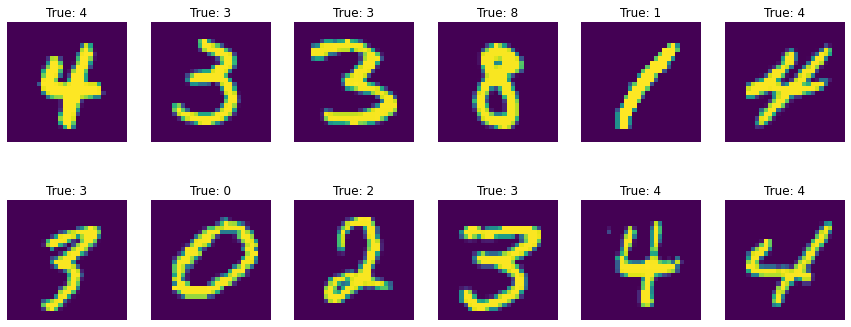

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
for axes_row in axes:
    for ax in axes_row:
        test_index = rng.integers(0, len(TestDS_orig))
        image, orig_label = TestDS_orig[test_index]
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i' % orig_label)


In [7]:
def target_transform(inlabel):
    newlabel = torch.zeros(10)
    newlabel[inlabel] = 1.
    return newlabel

TrainDS = torchvision.datasets.MNIST(foldname, train=True, download=True,
            target_transform=target_transform, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307), (0.3081)),
                             ]))
TestDS = torchvision.datasets.MNIST(foldname, train=False,
            target_transform=target_transform, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307), (0.3081)),
                             ]))

TrainDL = torch.utils.data.DataLoader(TrainDS, shuffle=True, batch_size=200)
TestDL = torch.utils.data.DataLoader(TestDS, batch_size=1000)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Network = torch.nn.Sequential(      
    torch.nn.Conv2d(1, 12, (9, 9)),  
    torch.nn.MaxPool2d((2, 2)),     
    torch.nn.ReLU(),
    torch.nn.Conv2d(12, 24, (5, 5)), 
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((3, 3)),    
    torch.nn.Flatten(),            
    torch.nn.Linear(96, 256),      
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),       
)
Network.to(device=device)

totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(Network.parameters(), lr=0.3)

Sequential(
  (0): Conv2d(1, 12, kernel_size=(9, 9), stride=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=96, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=10, bias=True)
)
35610 trainable parameters


In [9]:
N = 20
labels = torch.zeros(1, 10, dtype=torch.float32)
labels[0, 3] = 1.
output = torch.full_like(labels, 1./N)
print(crit(output, labels))


tensor(2.3026)


In [10]:

Network.train()
epochs = range(1, 20) 

errorPlotTrain = []
errorPlotTest = []
accuracyPlotTrain = []
accuracyPlotTest = []

for e in tqdm(epochs):
    print('Epoch #',e)
    Network.train()
    tr_loss = 0.
    samples = 0
    accuracy = 0
  
    for inputs, labels in tqdm(TrainDL, leave=False):
        opt.zero_grad() 
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = Network(inputs) 
        loss = crit(outputs, labels)
        loss.backward() 
        opt.step() 
        tr_loss += loss.clone().cpu().item()*len(inputs)
        accuracy += torch.sum(torch.eq(torch.max(labels, 1)[1], torch.max(outputs, 1)[1]), dtype=int).clone().cpu().item()
        samples += len(inputs) 
    tr_loss /= samples 
    errorPlotTrain.append(tr_loss)
    accuracy /= samples
    accuracyPlotTrain.append(accuracy)

    print('Training loss: %f, accuracy: %f' % (tr_loss, accuracy))
    
    Network.eval()

    with torch.no_grad():
        te_loss = 0.
        samples = 0
        accuracy = 0
       
        for inputs, labels in tqdm(TestDL):
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            outputs = Network(inputs)
            loss = crit(outputs, labels)
            te_loss += loss.clone().cpu().item()*len(inputs)
           
            m = torch.nn.Softmax(dim=1)
            outputs = m(outputs)
            accuracy += torch.sum(torch.eq(torch.max(labels, 1)[1], torch.max(outputs, 1)[1]), dtype=int).clone().cpu().item()
            samples += len(inputs)
        te_loss /= samples
        errorPlotTest.append(te_loss)
        accuracy /= samples
        accuracyPlotTest.append(accuracy)
        print('Test loss: %f, accuracy: %f' % (te_loss, accuracy))

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch # 1


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.402261, accuracy: 0.869633


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.082954, accuracy: 0.974500
Epoch # 2


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.075081, accuracy: 0.976250


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.053590, accuracy: 0.982800
Epoch # 3


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.053151, accuracy: 0.982633


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.047544, accuracy: 0.985600
Epoch # 4


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.044126, accuracy: 0.985933


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.065486, accuracy: 0.980400
Epoch # 5


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.036493, accuracy: 0.988417


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.036625, accuracy: 0.988300
Epoch # 6


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.032181, accuracy: 0.989633


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.066808, accuracy: 0.979300
Epoch # 7


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.026929, accuracy: 0.991317


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.037240, accuracy: 0.987700
Epoch # 8


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.021826, accuracy: 0.993050


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.036053, accuracy: 0.989000
Epoch # 9


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.019322, accuracy: 0.993683


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.037627, accuracy: 0.986600
Epoch # 10


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.017297, accuracy: 0.994233


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.040468, accuracy: 0.988200
Epoch # 11


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.015971, accuracy: 0.994917


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.037057, accuracy: 0.989600
Epoch # 12


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.013923, accuracy: 0.995283


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.041357, accuracy: 0.988600
Epoch # 13


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.010735, accuracy: 0.996417


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.038655, accuracy: 0.988500
Epoch # 14


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.011694, accuracy: 0.996300


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.041773, accuracy: 0.988600
Epoch # 15


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.010173, accuracy: 0.996200


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.038560, accuracy: 0.989300
Epoch # 16


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.007323, accuracy: 0.997600


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.039578, accuracy: 0.990000
Epoch # 17


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.008767, accuracy: 0.997050


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.052373, accuracy: 0.987100
Epoch # 18


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.009342, accuracy: 0.996683


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.037975, accuracy: 0.990100
Epoch # 19


  0%|          | 0/300 [00:00<?, ?it/s]

Training loss: 0.005906, accuracy: 0.998167


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.050829, accuracy: 0.988000


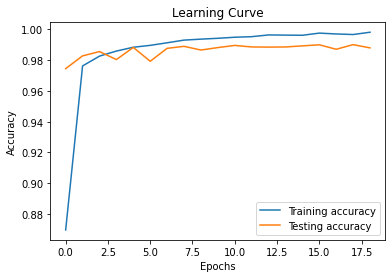

In [11]:
plt.plot(accuracyPlotTrain, label='Training accuracy')
plt.plot(accuracyPlotTest, label='Testing accuracy')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


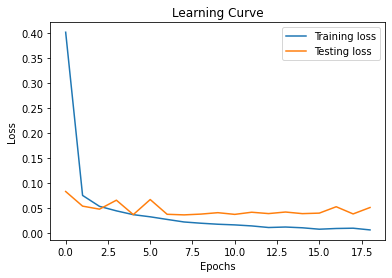

In [12]:
plt.plot(errorPlotTrain, label='Training loss')
plt.plot(errorPlotTest, label='Testing loss')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [13]:
Network.eval()

with torch.no_grad():
    te_loss = 0.
    samples = 0
    accuracy = 0
  
    for inputs, labels in tqdm(TestDL):
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = Network(inputs)
        loss = crit(outputs, labels)
        te_loss += loss.clone().cpu().item()*len(inputs)
        m = torch.nn.Softmax(dim=1)
        outputs = m(outputs)
        accuracy += torch.sum(torch.eq(torch.max(labels, 1)
                              [1], torch.max(outputs, 1)[1]), dtype=int).clone().cpu().item()
        samples += len(inputs)
    te_loss /= samples
    accuracy /= samples
    print('Test loss: %f, accuracy: %f' % (te_loss, accuracy))


  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.050829, accuracy: 0.988000


In [14]:
torch.save(Network, 'model_1.chk')


In [15]:
Network = torch.load('model_1.chk')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


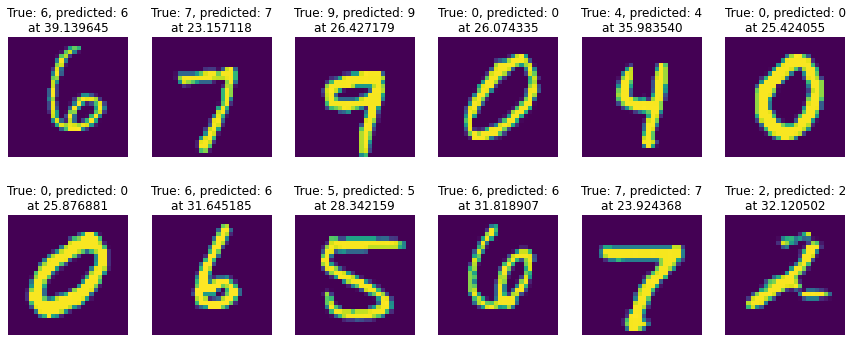

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
for axes_row in axes:
    for ax in axes_row:
        test_index = rng.integers(0, len(TestDS))
        sample, label = TestDS[test_index]
        image, orig_label = TestDS_orig[test_index]
        
        with torch.no_grad():
            output = Network(torch.unsqueeze(sample, dim=0).to(device=device))
            certainty, output = torch.max(output[0], 0)
            certainty = certainty.clone().cpu().item()
            output = output.clone().cpu().item()
        
        ax.set_axis_off()
        ax.imshow(image)

        ax.set_title('True: %i, predicted: %i\nat %f' % (orig_label, output, certainty))
